# Binary classification

In this notebook I will compare Similarity Forest to Random Forest in binary classification task. The Heart dataset comes from libsvm webiste, that is from the same source as in original Similarity Forest paper.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from simforest import SimilarityForestClassifier, SimilarityTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.model_selection import ValidationCurve, LearningCurve
from yellowbrick.classifier import ClassificationReport, class_prediction_error
from yellowbrick.classifier.threshold import discrimination_threshold
from yellowbrick.target import ClassBalance
from utils import plot_model_selection, plot_confusion_matrix
from yellowbrick.classifier.rocauc import roc_auc

%matplotlib inline
pd.options.display.max_columns = 500

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

/home/sfczekalski/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


I randomly shuffle the data, and split it to get training and testing set. It is also crucial to scale the features.

In [2]:
X, y = load_svmlight_file('../data/heart')
X = X.toarray()

random_state = np.random.RandomState(42)
shuffled_indices = random_state.permutation(len(y))
X, y = X[shuffled_indices], y[shuffled_indices]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Class proportion is approximately balanced.

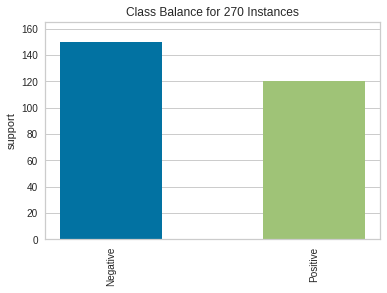

In [3]:
classes = ['Negative', 'Positive']
class_visualizer = ClassBalance(labels=classes)

class_visualizer.fit(y)
plt.xticks(rotation=90)
class_visualizer.show();

Similarity Forest classification report

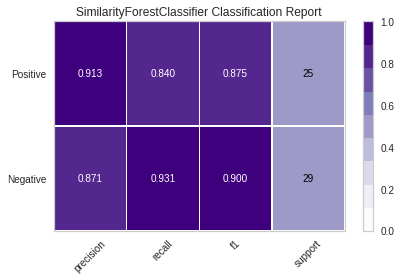

In [4]:
sf = SimilarityForestClassifier(n_estimators=100, random_state=42)
sf_visualizer = ClassificationReport(sf, classes=classes, support=True, cmap='Purples')

sf_visualizer.fit(X_train, y_train)
sf_visualizer.score(X_test, y_test)
sf_visualizer.show();

Random Forest classification report

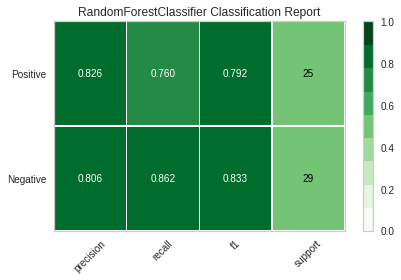

In [5]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_visualizer = ClassificationReport(rf, classes=classes, support=True, cmap='Greens')

rf_visualizer.fit(X_train, y_train)
rf_visualizer.score(X_test, y_test)
rf_visualizer.show();

Similarity Forest confusion matrix

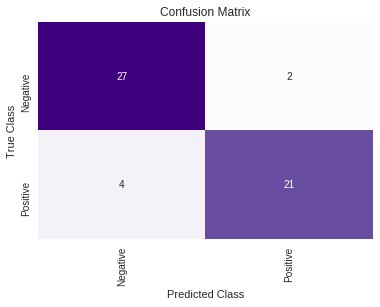

In [6]:
plot_confusion_matrix(sf_visualizer, X_test, y_test, classes=classes, cmap='Purples')

Random Forest confusion matrix

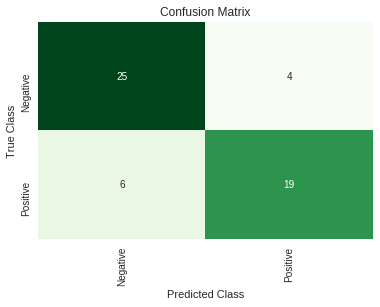

In [7]:
plot_confusion_matrix(rf_visualizer, X_test, y_test, classes=classes, cmap='Greens')

ROC curves for the classifiers

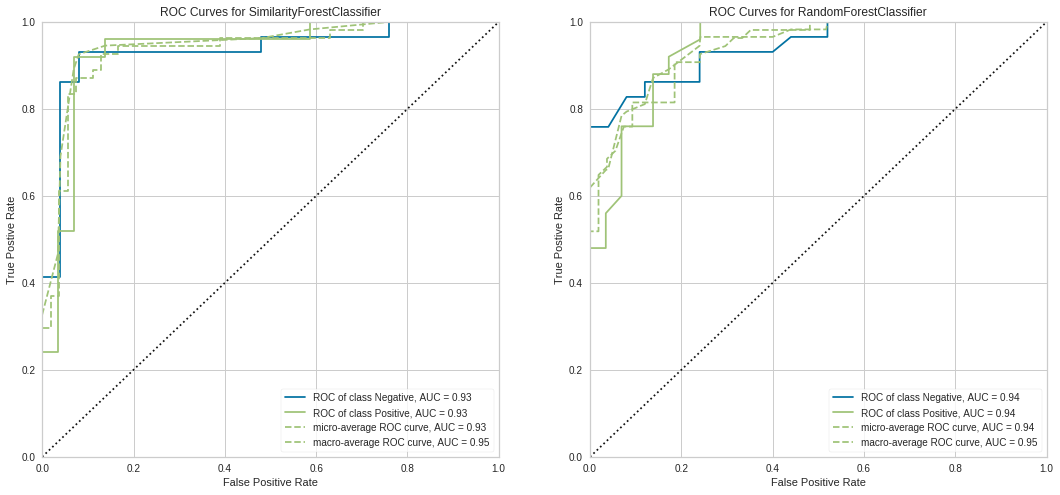

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
roc_auc(sf, X_train, y_train, X_test, y_test, ax=ax[0], classes=classes, show=False);
roc_auc(rf, X_train, y_train, X_test, y_test, ax=ax[1], classes=classes, show=False);
plt.show()

We can see that Random Forest is a bit more biased towards negative class.

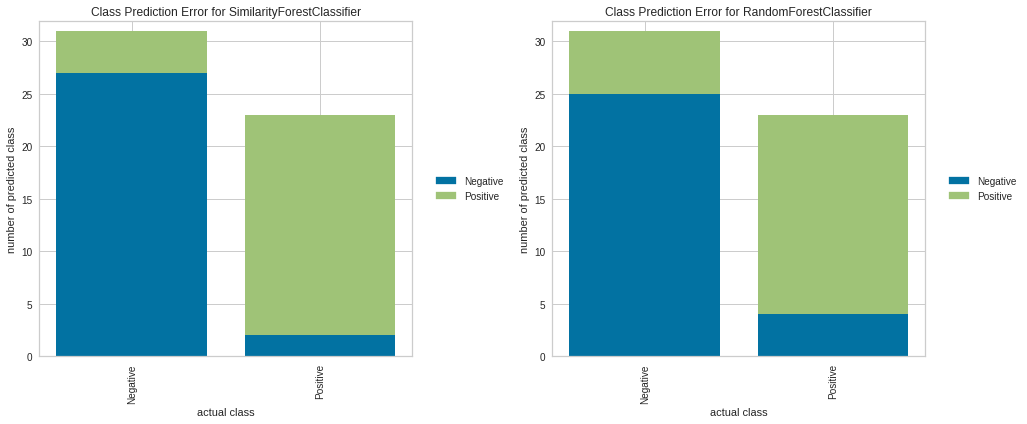

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
class_prediction_error(sf, X_train, y_train, X_test, y_test, ax=ax[0], classes=classes, show=False);
class_prediction_error(rf, X_train, y_train, X_test, y_test, ax=ax[1], classes=classes, show=False);
plt.show()

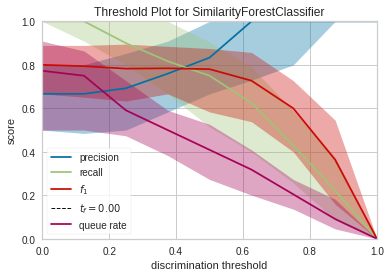

In [10]:
discrimination_threshold(sf, X_train, y_train);

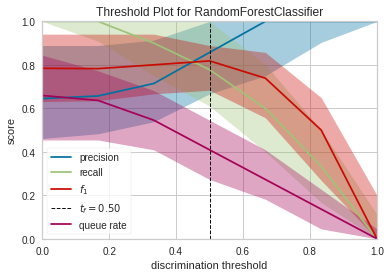

In [11]:
discrimination_threshold(rf, X_train, y_train);

# Model selection

We can observe how choosing the number of trees in the forest, and number of split direction tried at each node influence the classification.

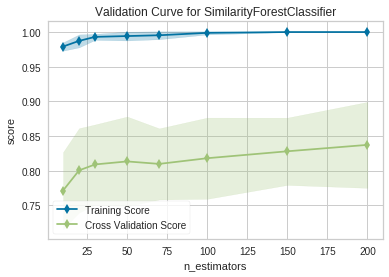

In [12]:
sf_visualizer = ValidationCurve(
    SimilarityForestClassifier(), param_name='n_estimators',
    param_range=[10, 20, 30, 50, 70, 100, 150, 200], cv=5, scoring='f1_weighted'
)

sf_visualizer.fit(X_train, y_train)
sf_visualizer.show();

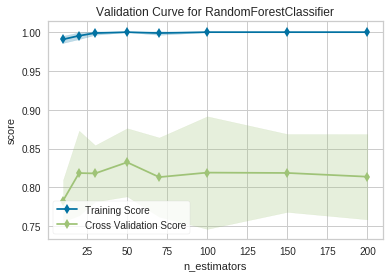

In [13]:
rf_visualizer = ValidationCurve(
    RandomForestClassifier(), param_name='n_estimators',
    param_range=[10, 20, 30, 50, 70, 100, 150, 200], cv=5, scoring='f1_weighted'
)

rf_visualizer.fit(X_train, y_train)
rf_visualizer.show();

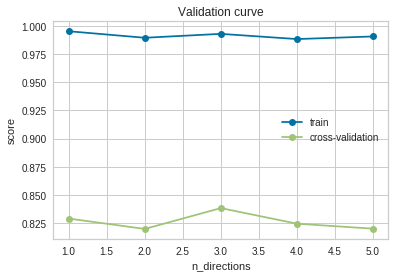

In [14]:
_ = plot_model_selection(SimilarityForestClassifier(n_estimators=30), 'n_directions', [1, 2, 3, 4, 5], X_train, y_train)

# Learning curve

Learning curve helps us understand how classification results improve with growing amount of data.

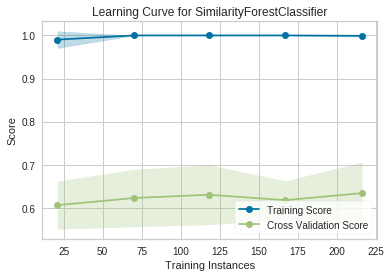

In [15]:
cv = StratifiedKFold(n_splits=5)

sf = SimilarityForestClassifier(n_estimators=100)
sf_visualizer = LearningCurve(sf, cv=cv, scoring='f1_weighted', n_jobs=4)

sf_visualizer.fit(X, y)
sf_visualizer.show();

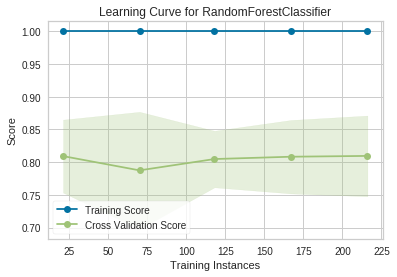

In [16]:
cv = StratifiedKFold(n_splits=5)

rf = RandomForestClassifier()
rf_visualizer = LearningCurve(rf, cv=cv, scoring='f1_weighted', n_jobs=4)

rf_visualizer.fit(X, y)
rf_visualizer.show();

# Single trees

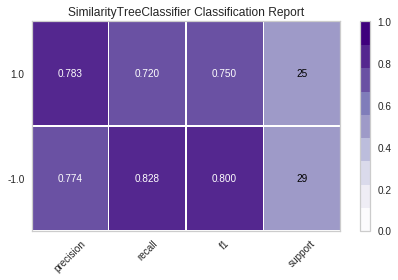

In [17]:
st = SimilarityTreeClassifier(random_state=42)
st_visualizer = ClassificationReport(st, support=True, cmap='Purples')

st_visualizer.fit(X_train, y_train)
st_visualizer.score(X_test, y_test)
st_visualizer.show();

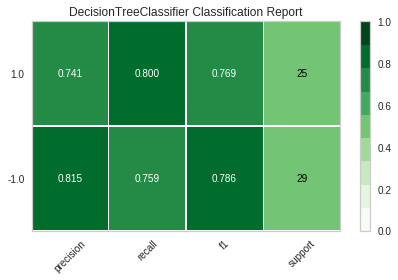

In [18]:
dt = DecisionTreeClassifier(random_state=42)
dt_visualizer = ClassificationReport(dt, support=True, cmap='Greens')

dt_visualizer.fit(X_train, y_train)
dt_visualizer.score(X_test, y_test)
dt_visualizer.show();

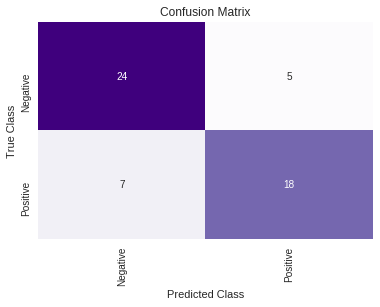

In [19]:
plot_confusion_matrix(st_visualizer, X_test, y_test, classes=classes, cmap='Purples')

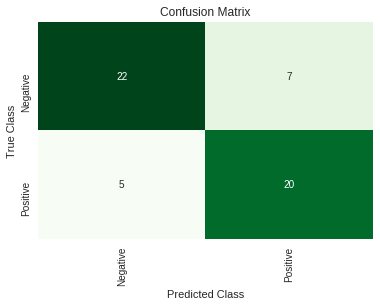

In [20]:
plot_confusion_matrix(dt_visualizer, X_test, y_test, classes=classes, cmap='Greens')

Roc curve for both trees

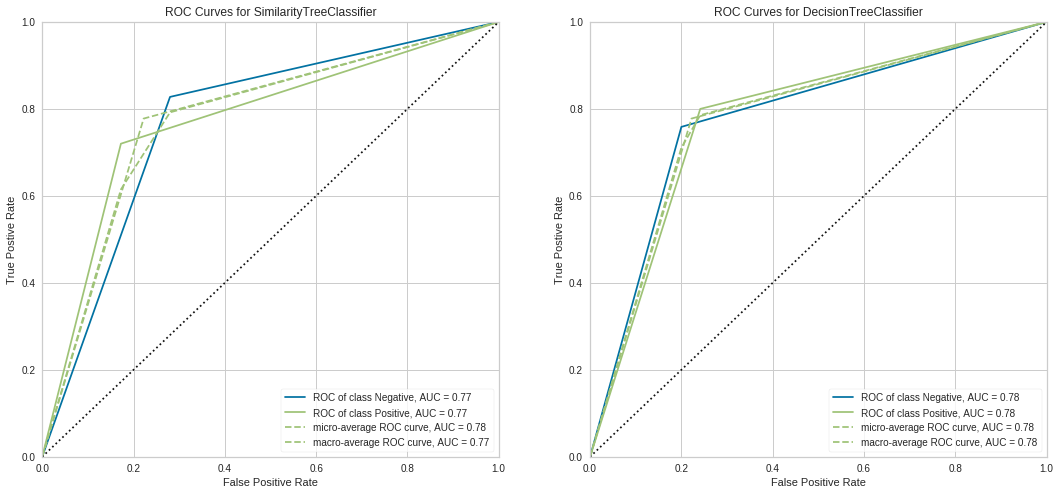

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
roc_auc(st, X_train, y_train, X_test, y_test, ax=ax[0], classes=classes, show=False);
roc_auc(dt, X_train, y_train, X_test, y_test, ax=ax[1], classes=classes, show=False);
plt.show()

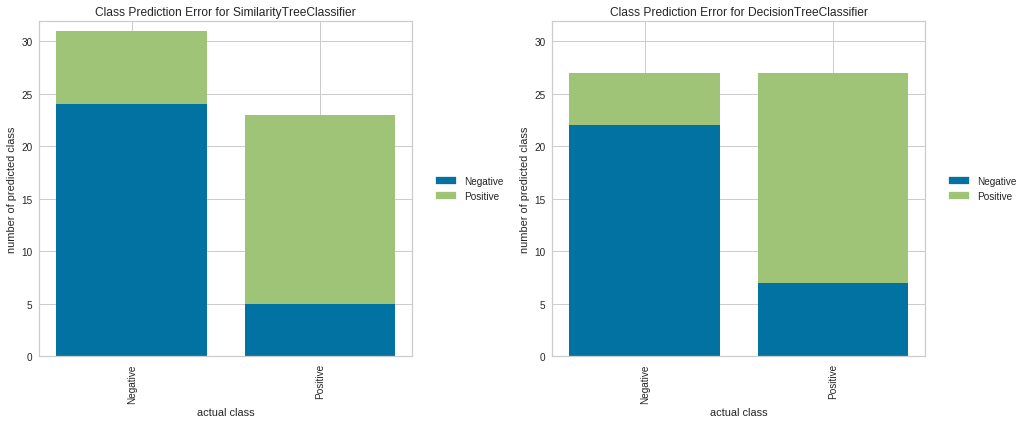

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
class_prediction_error(st, X_train, y_train, X_test, y_test, ax=ax[0], classes=classes, show=False);
class_prediction_error(dt, X_train, y_train, X_test, y_test, ax=ax[1], classes=classes, show=False);
plt.show()

# Single tree model selection

We can check how predictions change with varying maximal depth of a tree. It is also worth to check number of split directions at each tree node.

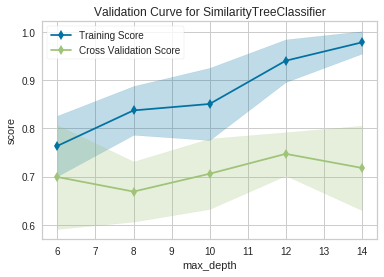

In [23]:
st_visualizer = ValidationCurve(
    SimilarityTreeClassifier(), param_name='max_depth',
    param_range=[6, 8, 10, 12, 14], cv=5, scoring='f1_weighted'
)

st_visualizer.fit(X_train, y_train)
st_visualizer.show();

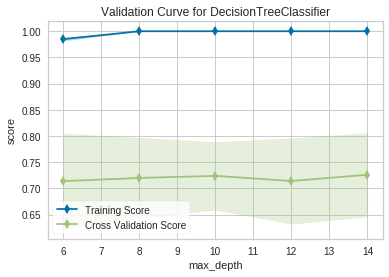

In [24]:
dt_visualizer = ValidationCurve(
    DecisionTreeClassifier(), param_name='max_depth',
    param_range=[6, 8, 10, 12, 14], cv=5, scoring='f1_weighted'
)

dt_visualizer.fit(X_train, y_train)
dt_visualizer.show();

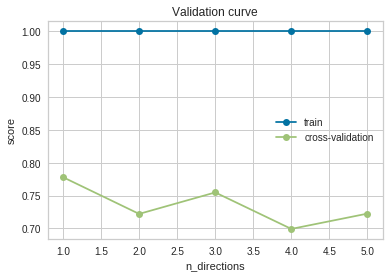

In [25]:
_ = plot_model_selection(SimilarityTreeClassifier(), 'n_directions', [1, 2, 3, 4, 5], X_train, y_train)

# Single tree learning curve

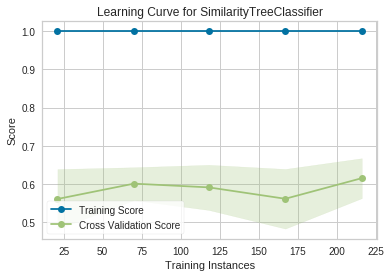

In [26]:
cv = StratifiedKFold(n_splits=5)

st = SimilarityTreeClassifier()
st_visualizer = LearningCurve(st, cv=cv, scoring='f1_weighted', n_jobs=4)

st_visualizer.fit(X, y)
st_visualizer.show();

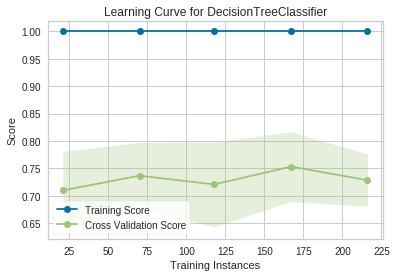

In [27]:
cv = StratifiedKFold(n_splits=5)

dt = DecisionTreeClassifier()
dt_visualizer = LearningCurve(dt, cv=cv, scoring='f1_weighted', n_jobs=4)

dt_visualizer.fit(X, y)
dt_visualizer.show();